In [1]:
import os
from keras.models import Sequential
from keras import layers, regularizers, optimizers
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import requests
import json
import numpy as np
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from datetime import datetime

Using TensorFlow backend.


In [2]:
#### Read from CSV
my_data = np.genfromtxt('e:\EURUSD.csv', delimiter=',', skip_header=1)
my_data = np.delete(my_data, 1, 1)
for i, data in enumerate(my_data):
    my_data[i][0] = (datetime.strptime(str(data[0]), "%Y%m%d.0")).isoweekday()
my_data = my_data[np.logical_not(my_data[:,0] == 7)]
bin_days = to_categorical(my_data[:,0])
my_data = np.delete(my_data, 0, 1)
#my_data = np.concatenate((bin_days, my_data), axis=1)

In [3]:
#### Read from DB
# auth_url = 'http://185.49.144.175/api/token/'
# bar_url = 'http://185.49.144.175/api/bars/?timeframe=1'
# headers = {'Content-type': 'application/json', 'Content-Encoding': 'utf-8'}
# data = {"username": "lim","password": "Serialnomberr3"}
# answer = requests.post(auth_url, data=json.dumps(data), headers=headers)
# response = answer.json()
# token = response['access']
# headers = {'Authorization': 'Bearer ' + token}
# answer = requests.get(bar_url, headers=headers)
# response = answer.json()
# f_data = np.zeros((len(response), 6))
# for i, bar in enumerate(response):
#     date = datetime.strptime( bar['time'], "%Y-%m-%dT%H:%M:%SZ" )
#     values = [date.isoweekday(), float(bar['open']), float(bar['close']), float(bar['high']), float(bar['low']), float(bar['tick_volume'])]
#     f_data[i, :] = values
# f_data = np.flip(f_data,0)
# bin_days = to_categorical(f_data[:,0])
# f_data = np.delete(f_data, 0, 1)
# f_data = np.concatenate((bin_days, f_data), axis=1)

In [3]:
# Normalize tick_volume
f_data = np.delete(my_data, 4, 1)
f_data = np.delete(f_data, 0, 1)
f_data = np.delete(f_data, 0, 1)
f_data = np.delete(f_data, 0, 1)
#f_data = my_data
# for col in range(0,f_data.shape[-1]):
#     min = f_data[:1500000, col].min(axis=0)
#     max = f_data[:1500000, col].max(axis=0)
#     f_data[:, col] = (f_data[:, col] - min) / (max - min)

In [4]:
from matplotlib import pyplot as plt
close = f_data[:, 0]
plt.plot(range(len(close)), close)
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
f_data_train = f_data[:1500000,]
f_data_val = f_data[1500001:1800000,]
f_data_test = f_data[1800001:,]
print(f_data_train.shape)
print(f_data_val.shape)
print(f_data_test.shape)

(1500000, 1)
(299999, 1)
(25843, 1)


In [5]:
def generator(data, lookback, delay, max_index, min_index=0, shuffle=False, batch_size=128, step=30):
    if max_index is None: # Не задан конечный индекс
        max_index = len(data) - delay - 1 # Максимальный индекс расчитывается от длины массива - задержка - 1
    i = min_index
    while 1:
#         if shuffle:
#             rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
#         else:
        if i+lookback*batch_size+delay >= max_index: # Мы бужем выбирать look*batch_size строк начиная с i
            i = min_index # Начинаем сначала
        samples = np.zeros((batch_size, lookback, data.shape[-1]))
        targets = np.zeros((batch_size,))
        for j in range(0, batch_size):
            samples[j] = data[i+(j*step):i+(j*step)+lookback,:]
            targets[j] = float(data[i+lookback+delay+(j*step)][0] > data[i+lookback+(j*step)][0])
        i += step*batch_size
        yield samples, targets

In [6]:
lookback = 30
step = 30
delay = 30
batch_size = 1
train_gen = generator(f_data_train, lookback=lookback, delay=delay, min_index=0, max_index=None, step=step, batch_size=batch_size)
val_gen = generator(f_data_val, lookback=lookback, delay=delay, min_index=0, max_index=None, step=step, batch_size=batch_size)
test_gen = generator(f_data_test, lookback=lookback, delay=delay, min_index=0, max_index=None, step=step, batch_size=batch_size)

In [7]:
train_steps = (len(f_data_train)- delay) // (batch_size * step)
val_steps = (len(f_data_val) - delay) // (batch_size * step)
test_steps = (len(f_data_test) - delay) // (batch_size * step)

In [8]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [9]:
for i in train_gen:
    print(i[0].shape, i[1].shape)
    break

(1, 30, 1) (1,)


In [10]:
model = Sequential()
model.add(layers.CuDNNGRU(256, input_shape=(30, f_data.shape[-1]), return_sequences=False))
model.add(layers.Activation('tanh'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
sgd = optimizers.RMSprop()
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=120, callbacks=[checkpoint], validation_data=val_gen, validation_steps=val_steps)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/120
  450/49999 [..............................] - ETA: 21:37 - loss: 0.6972 - acc: 0.4711

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\a.lunev\Anaconda3\envs\ML_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)



KeyboardInterrupt



In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


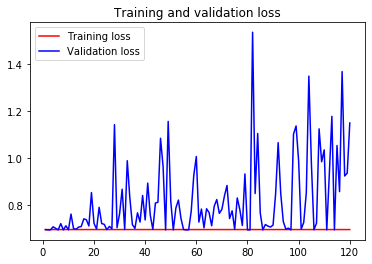

In [11]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [95]:
test_steps

-1501

In [113]:

scores = model.evaluate_generator(test_gen, steps=test_steps)
scores

array([[0.31980315],
       [0.31928673],
       [0.3184727 ],
       [0.31842822],
       [0.3188224 ],
       [0.31886315],
       [0.3189134 ],
       [0.31881487],
       [0.31826147],
       [0.317867  ],
       [0.31886587],
       [0.3179749 ],
       [0.31763607],
       [0.31719503],
       [0.3162192 ],
       [0.31467667],
       [0.31355426],
       [0.31071964],
       [0.3090073 ],
       [0.30876932],
       [0.3073149 ],
       [0.30744806],
       [0.30832925],
       [0.3085157 ],
       [0.3089402 ],
       [0.30877006],
       [0.3092127 ],
       [0.31081444],
       [0.3084266 ],
       [0.308567  ],
       [0.30918267],
       [0.31000355],
       [0.3118138 ],
       [0.31104147],
       [0.30931365],
       [0.30960035],
       [0.30614692],
       [0.3093303 ],
       [0.30710974],
       [0.3079637 ],
       [0.31980315],
       [0.31928673],
       [0.3184727 ],
       [0.31842822],
       [0.3188224 ],
       [0.31886315],
       [0.3189134 ],
       [0.318

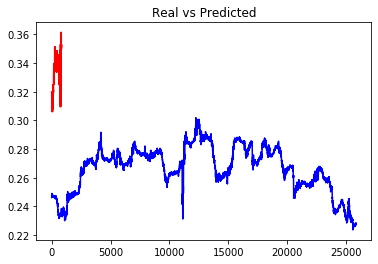

In [114]:
from matplotlib import pyplot as plt
close = f_data[:, 0]
plt.plot(range(len(scores)), scores, 'r', label='Predicted')
plt.plot(range(len(f_data_test)), f_data_test, 'b', label='Real')
plt.title('Real vs Predicted')
plt.show()

In [255]:
pred[0][0]

1.0

In [253]:
r_data[0][29]

array([0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 1.09108   , 1.09116   , 1.09107   , 1.09111   ,
       0.10588235])